In [9]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
from coherenceModel import *
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
paragraph_df = pd.read_csv('aviationPerms.csv')
paragraph_df

,paragraph,is_coherent
0,The preflight inspection of the fuel tanks by ...,1
1,"The pilot reported that he was cleared to 4,00...",1
2,The instrument-rated private pilot lost contro...,1
3,The non-instrument rated private pilot was rec...,1
4,The commercial pilot reported a partial power ...,1
...,...,...
2095,THE FUEL SELECTOR WAS POSITIONED ON THE RIGHT ...,0
2096,DURING AN INTENTIONAL MANEUVER TO AVOID A HOME...,0
2097,RESIDUAL FUEL WAS FOUND IN THE CARBURETOR BOWL...,0
2098,"AT A 75% POWER SETTING, FUEL FLOW IS ABOUT 10....",0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    paragraph_df.paragraph.values, 
    paragraph_df.is_coherent.values,
    stratify = paragraph_df.is_coherent.values,
    test_size = 0.1, 
    random_state = 487
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    stratify = y_train,
    test_size = 0.2, 
    random_state = 487
)
print(X_train[0])
print(y_train[0])

Routine air work was performed and then touch-and-go landing practice was planned. The approach and landing on runway 34 was normal. During the takeoff roll the pilot noticed that unusual stick forces were required to raise the tail wheel. FAA inspectors examined the airplane and did not report finding any trim or control system irregularity; however, the fuselage distortion precluded a complete examination. He saw a row of sailplanes parked on runway 30 in his path and elected to turn off the runway into sagebrush and grass. He decided to abort the takeoff and applied forward stick to prevent the airplane from leaping off the runway in a stalled condition. The trim setting was rechecked and confirmed. The pilot added some additional nose down trim, but no relief of stick pressure was noticed. He was drifting to the right and approaching the intersection of runway 30 at this time. The right main landing gear fell into a ditch and collapsed, buckling and distorting the fuselage. Trim wa

In [96]:
import gensim.downloader
embed = gensim.downloader.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [147]:
train_data = WindowedParDataset(X_train, y_train, embed, 5)
dev_data = WindowedParDataset(X_val, y_val, embed, 5)
test_data = WindowedParDataset(X_test, y_test, embed, 5)

In [148]:
train_loader = DataLoader(train_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=True)
test_loader = DataLoader(test_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=False)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [183]:
num_pos = len(paragraph_df[paragraph_df["is_coherent"] == 1])
num_neg = len(paragraph_df[paragraph_df["is_coherent"] == 0])
dampen = 1.5
pos_weight = torch.Tensor([num_neg / num_pos / dampen]).to(device)
pos_weight

tensor([13.3333], device='cuda:0')

------------------------ Start Training ------------------------
Epoch No. 1--Iteration No. 133-- batch loss = 0.8860
Validation UAR: 0.5543
Validation accuracy: 0.8260
Validation loss: 1.0377
Epoch No. 2--Iteration No. 266-- batch loss = 0.8012
Validation UAR: 0.5889
Validation accuracy: 0.8528
Validation loss: 0.9722
Epoch No. 3--Iteration No. 399-- batch loss = 0.4562
Validation UAR: 0.6501
Validation accuracy: 0.8356
Validation loss: 0.8979
Epoch No. 4--Iteration No. 532-- batch loss = 0.7648
Validation UAR: 0.7529
Validation accuracy: 0.7416
Validation loss: 0.8420
Epoch No. 5--Iteration No. 665-- batch loss = 0.8389
Validation UAR: 0.7792
Validation accuracy: 0.7416
Validation loss: 0.7777
Epoch No. 6--Iteration No. 798-- batch loss = 0.7919
Validation UAR: 0.7735
Validation accuracy: 0.7919
Validation loss: 0.7439
Epoch No. 7--Iteration No. 931-- batch loss = 0.5785
Validation UAR: 0.8105
Validation accuracy: 0.7732
Validation loss: 0.7074
Epoch No. 8--Iteration No. 1064-- batch

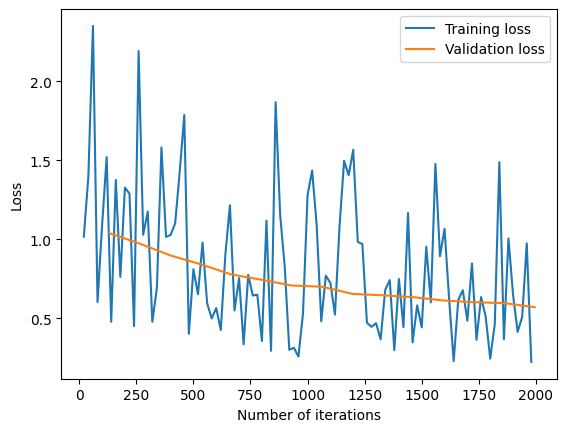

In [184]:
# test on validation to see if overfit is possible
ffnn = FFNN(3, device)
ffnn.to(device)
optim = get_optimizer(ffnn, lr=1e-2, weight_decay=0)
best_model, stats = train_model(ffnn, dev_loader, dev_loader, optim, pos_weight=pos_weight,
                                num_epoch=15, collect_cycle=20, device=device, patience=None)
plot_loss(stats)

In [181]:
################ SET THIS TO CHANGE WINDOW SIZE OF THINGS BELOW:
wsize = 3
################
train_data = WindowedParDataset(X_train, y_train, embed, wsize)
dev_data = WindowedParDataset(X_val, y_val, embed, wsize)
test_data = WindowedParDataset(X_test, y_test, embed, wsize)
train_loader = DataLoader(train_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=True)
test_loader = DataLoader(test_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=False)

In [185]:
import itertools
from tqdm.notebook import tqdm

torch.cuda.empty_cache()

def search_param_utterance(wsize):
    """Experiemnt on different hyper parameters."""
    learning_rate, weight_decay = get_hyper_parameters()
    window_sizes = [wsize]
    print("learning rate from: {}\nweight_decay from: {}\nwindow from: {}".format(
        learning_rate, weight_decay, window_sizes
    ))
    best_model, best_stats = None, None
    best_accuracy, best_lr, best_wd, best_window_size = 0, 0, 0, 0
    for lr, wd, window_size in tqdm(itertools.product(learning_rate, weight_decay, window_sizes),
                           total=len(learning_rate) * len(weight_decay) * len(window_sizes)):
        net = FFNN(window_size, device).to(device)
        optim = get_optimizer(net, lr=lr, weight_decay=wd)
        model, stats = train_model(net, train_loader, dev_loader, optim, pos_weight=pos_weight, 
                                   num_epoch=100, collect_cycle=500, device=device, 
                                   verbose=True, patience=None, stopping_criteria='accuracy')
        # print accuracy
        print(f"{(lr, wd, window_size)}: {stats['accuracy']}")
        # update best parameters if needed
        if stats['accuracy'] > best_accuracy:
            best_accuracy = stats['accuracy']
            best_model, best_stats = model, stats
            best_lr, best_wd, best_window_size = lr, wd, window_size
            torch.save(best_model.state_dict(), 'best_rnn.pt')
    print("\n\nBest learning rate: {}, best weight_decay: {}, best window: {}".format(
        best_lr, best_wd, best_window_size))
    print("Accuracy: {:.4f}".format(best_accuracy))
    plot_loss(best_stats)
    return best_model
basic_model = search_param_utterance(wsize)

learning rate from: [0.01]
weight_decay from: [0.005, 0.05, 0.125, 0.25, 0.5, 0.625, 1.0, 1.25, 2.5]
window from: [3]


  0%|          | 0/9 [00:00<?, ?it/s]

------------------------ Start Training ------------------------
Epoch No. 1--Iteration No. 499-- batch loss = 1.2049
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0862
Epoch No. 2--Iteration No. 998-- batch loss = 1.8758
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0877
Epoch No. 3--Iteration No. 1497-- batch loss = 1.8556
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0858
Epoch No. 4--Iteration No. 1996-- batch loss = 1.2174
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0869
Epoch No. 5--Iteration No. 2495-- batch loss = 1.8560
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0851
Epoch No. 6--Iteration No. 2994-- batch loss = 0.5612
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0879
Epoch No. 7--Iteration No. 3493-- batch loss = 3.7418
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0885
Epoch No. 8--Iteration No. 3992-- 

Validation UAR: 0.4461
Validation accuracy: 0.8040
Validation loss: 1.2137
Epoch No. 64--Iteration No. 31936-- batch loss = 0.4792
Validation UAR: 0.4577
Validation accuracy: 0.8595
Validation loss: 1.2145
Epoch No. 65--Iteration No. 32435-- batch loss = 1.6784
Validation UAR: 0.4647
Validation accuracy: 0.8673
Validation loss: 1.2132
Epoch No. 66--Iteration No. 32934-- batch loss = 1.9519
Validation UAR: 0.4478
Validation accuracy: 0.7738
Validation loss: 1.2121
Epoch No. 67--Iteration No. 33433-- batch loss = 1.7435
Validation UAR: 0.4543
Validation accuracy: 0.7973
Validation loss: 1.2205
Epoch No. 68--Iteration No. 33932-- batch loss = 1.7215
Validation UAR: 0.4523
Validation accuracy: 0.8215
Validation loss: 1.2239
Epoch No. 69--Iteration No. 34431-- batch loss = 1.1297
Validation UAR: 0.4507
Validation accuracy: 0.8185
Validation loss: 1.2224
Epoch No. 70--Iteration No. 34930-- batch loss = 1.3293
Validation UAR: 0.4610
Validation accuracy: 0.8658
Validation loss: 1.2278
Epoch No

Epoch No. 25--Iteration No. 12475-- batch loss = 0.5693
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0834
Epoch No. 26--Iteration No. 12974-- batch loss = 1.1894
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0877
Epoch No. 27--Iteration No. 13473-- batch loss = 0.5562
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0859
Epoch No. 28--Iteration No. 13972-- batch loss = 0.5710
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0908
Epoch No. 29--Iteration No. 14471-- batch loss = 0.5690
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0834
Epoch No. 30--Iteration No. 14970-- batch loss = 0.5647
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0866
Epoch No. 31--Iteration No. 15469-- batch loss = 0.5527
Validation UAR: 0.5000
Validation accuracy: 0.9511
Validation loss: 1.0857
Epoch No. 32--Iteration No. 15968-- batch loss = 1.8163
Validation UAR: 0.5000
Vali

KeyboardInterrupt: 

In [ ]:
uar, accuracy, total_loss = get_validation_performance(
    basic_model, 
    nn.BCEWithLogitsLoss(pos_weight=pos_weight), 
    test_loader, 
    device
)
print("Test UAR: {:.4f}".format(uar))
print("Test accuracy: {:.4f}".format(accuracy))
print("Test loss: {:.4f}".format(loss))